<a href="https://colab.research.google.com/github/14-shru/Assignments/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTS**

In [1]:
!pip install scikit-learn==0.21.3
!pip install wget==3.2
!pip install gensim==3.6.0
!pip install psutil==5.4.8
!pip install spacy==2.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 3.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b7761b42e2ac67e6d02e1a61c0f4b2457e0f7dd8d0bce5e36affd2fbba307912
  Stored in directory: /root/.cache/pip/w

In [4]:
import requests
import urllib
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML
import keras.layers as layers
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape,Embedding,BatchNormalization,Dot,LSTM,Concatenate
from tensorflow.keras import Sequential
from collections import Counter


from sklearn.model_selection import train_test_split

**Verify Setup**

In [5]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


**LOAD AND PRE-PROCESS THE DATASET**

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
df = pd.read_csv (r'/content/drive/MyDrive/research/IMDB Dataset.csv')
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [47]:
def download_and_load_datasets(force_download=False):
    
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "IMDB Dataset.csv", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "IMDB Dataset.csv", "test"))
    return train_df, test_df

In [48]:
def download_and_load_datasets_local(force_download=False):
  
    train_df = load_dataset(os.path.join(os.path.dirname("./dataset/"), 
                                       "IMDB Dataset.csv", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname("./dataset/"), 
                                      "IMDB Dataset.csv", "test"))
  
    return train_df, test_df

    train_df, test_df = download_and_load_datasets()
    print(train_df.head())

In [49]:
max_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_words)

In [50]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [57]:
#train dataset
train_reviews=df.review[:40000]
train_sentiments=df.sentiment[:40000]
#test dataset
test_reviews=df.review[40000:]
test_sentiments=df.sentiment[40000:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(10000,) (10000,)


In [61]:
train = list(zip(X_train, y_train))
random.shuffle(train)
X_train, y_train = zip(*train)
y_train = np.array(y_train)

X_train = sequence.pad_sequences(X_train, maxlen=SEQ_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=SEQ_LENGTH)

*Load the word2vec embeddings*

In [22]:
import os
import wget
import gzip
import shutil

gn_vec_path = "GoogleNews-vectors-negative300.bin"
if not os.path.exists("GoogleNews-vectors-negative300.bin"):
    if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin"):
        #Downloading the reqired model
        if not os.path.exists("../Ch2/GoogleNews-vectors-negative300.bin.gz"):
            if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
                wget.download("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz")
            gn_vec_zip_path = "GoogleNews-vectors-negative300.bin.gz"
        else:
            gn_vec_zip_path = "../Ch2/GoogleNews-vectors-negative300.bin.gz"
        #Extracting the required model
        with gzip.open(gn_vec_zip_path, 'rb') as f_in:
            with open(gn_vec_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        gn_vec_path = "../Ch2/" + gn_vec_path

print(f"Model at {gn_vec_path}")

Model at GoogleNews-vectors-negative300.bin


In [62]:
import warnings #This module ignores the various types of warnings generated
warnings.filterwarnings("ignore") 

import psutil #This module helps in retrieving information on running processes and system resource utilization
process = psutil.Process(os.getpid())
from psutil import virtual_memory
mem = virtual_memory()

import time #This module is used to calculate the time  

**Define and train the model**

In [65]:
pip install --upgrade simple_elmo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.8 MB/s 


In [66]:
from simple_elmo import ElmoModel

model = ElmoModel()

In [76]:
!wget https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec -O /tmp/wiki.multi.en.vec

--2022-07-19 09:11:23--  https://s3.amazonaws.com/arrival/embeddings/wiki.multi.en.vec
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.113.77
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.113.77|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: unspecified
ERROR: Redirection (301) without location.


In [85]:
import numpy as np

def load_vectors(embedding_file_path):
    print("Loading vectors from", embedding_file_path)
    embeddings = []
    word2id = {}

In [119]:
with open(embedding_file_path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, emb = line.rstrip().split(' ', 1)
            emb = np.fromstring(emb, sep=' ')
            assert word not in word2id, 'word found twice'
            embeddings.append(emb)
            word2id[word] = len(word2id)
            embeddings = np.vstack(embeddings)
            
            return embeddings, word2id

embeddings_en, embedding_word2id_en = load_vectors("/tmp/wiki.multi.en.vec")
            

SyntaxError: ignored

In [89]:
def create_embedding_matrix(target_word2id, embedding_word2id, embeddings, num_rows, num_columns):
    embedding_matrix = np.zeros((num_rows, num_columns))
    for word, i in target_word2id.items():
        if i >= num_rows:
            continue
        if word in embedding_word2id: 
            embedding_matrix[i] = embeddings[embedding_word2id[word]]
    return embedding_matrix

In [92]:
word2id_en = imdb.get_word_index()
word2id_en = {k:(v+INDEX_FROM) for k,v in word2id_en.items()}
word2id_en["<PAD>"] = 0
word2id_en["<START>"] = START_INDEX
word2id_en["<UNK>"] = OOV_INDEX

In [102]:
embedding_matrix_en = create_embedding_matrix(word2id_en, embedding_word2id_en, 
                                              embeddings_en, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)

NameError: ignored

In [79]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Lambda, Input
from keras.layers import Flatten, Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model


ELMO_EMBEDDING_DIM = 1024

def ElmoEmbedding(x):
    y = elmo_model(tf.squeeze(x), signature="default", as_dict=True)["elmo"]
    return y

def create_basic_model():
    sequence = Input(shape=(500,))
    embedding = Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, 
                              weights=[embedding_matrix_en], trainable=False)(sequence)
        
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=SEQ_LENGTH)(conv)
    flat = Flatten()(pool)
    dense = Dense(250, activation='relu')(flat)
    prediction = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=sequence, outputs=prediction)
    optimizer = Adam(lr=0.0001, decay=1e-3)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #print(model.summary())
    
    return model
    
    
def create_elmo_model(): 
    token_sequence = Input(shape=(1,), dtype="string", name="elmo_input")
    index_sequence = Input(shape=(SEQ_LENGTH,), name="standard_input")

    embedding1 = Lambda(ElmoEmbedding, output_shape=(SEQ_LENGTH, ELMO_EMBEDDING_DIM,))(token_sequence)
    embedding2 = Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, 
                          weights=[embedding_matrix_en], trainable=False)(index_sequence)
    embedding = Concatenate()([embedding1, embedding2])
        
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=SEQ_LENGTH)(conv)
    flat = Flatten()(pool)
    dense = Dense(250, activation='relu')(flat)
    prediction = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[index_sequence, token_sequence], outputs=prediction)
    optimizer = Adam(lr=0.00001, decay=1e-3)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #print(model.summary())
    
    return model

**TRAINING**

In [80]:
import math

def train_basic_model(model, X_train, y_train, X_val, y_val, X_test, y_test): 
    batch_size = 16
    earlystop = EarlyStopping(monitor='val_loss', patience=2) 
    checkpoint = ModelCheckpoint('basic_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=100, batch_size=batch_size, callbacks=[earlystop, checkpoint])
    model.load_weights(filepath='basic_model.hdf5')
    scores = model.evaluate(X_test, y_test, batch_size=batch_size)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]*100


def train_elmo_model(model, X_train, E_train, y_train, X_val, E_val, y_val, X_test, E_test, y_test): 
    batch_size = 16
    earlystop = EarlyStopping(monitor='val_loss', patience=2)        
    checkpoint = ModelCheckpoint('elmo_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    model.fit([X_train, E_train], y_train, validation_data=([X_val, E_val], y_val), 
              epochs=100, batch_size=batch_size, callbacks=[earlystop, checkpoint])
    model.load_weights(filepath='elmo_model.hdf5')
    scores = model.evaluate([X_test, E_test], y_test, batch_size=batch_size)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]*100

In [120]:
elmo_accuracies = []
basic_accuracies = []

test_size = 500
validation_size = 200
training_size = 200
id2word_en = {v:k for k,v in word2id_en.items()}

for i in range(10):     
    
    train = list(zip(X_train, y_train))
    test = list(zip(X_test, y_test))
    random.shuffle(train)
    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
            
    train_texts = [" ".join([id2word_en[idx] for idx in seq]) for seq in X_train[:training_size]]
    test_texts = [" ".join([id2word_en[idx] for idx in seq]) for seq in X_test[:test_size]]
    val_texts = [" ".join([id2word_en[idx] for idx in seq]) for seq in X_test[test_size:test_size+validation_size]]

    E_train = np.array(train_texts)
    E_test = np.array(test_texts)
    E_val = np.array(val_texts)
        
    model_baseline = create_basic_model()
    basic_acc = train_basic_model(model_baseline, X_train[:training_size], y_train[:training_size], 
                                  X_test[test_size:test_size+validation_size],
                                  y_test[test_size:test_size+validation_size], 
                                  X_test[:test_size], y_test[:test_size])
    basic_accuracies.append(basic_acc)

    model_elmo = create_elmo_model()
    elmo_acc = train_elmo_model(model_elmo, X_train[:training_size], E_train, y_train[:training_size],
                                X_test[test_size:test_size+validation_size], 
                                E_val, y_test[test_size:test_size+validation_size], 
                                X_test[:test_size], E_test, y_test[:test_size])
    elmo_accuracies.append(elmo_acc)
        
    print(basic_accuracies)
    print(elmo_accuracies)
    
print(np.mean(basic_accuracies))
print(np.mean(elmo_accuracies))

NameError: ignored

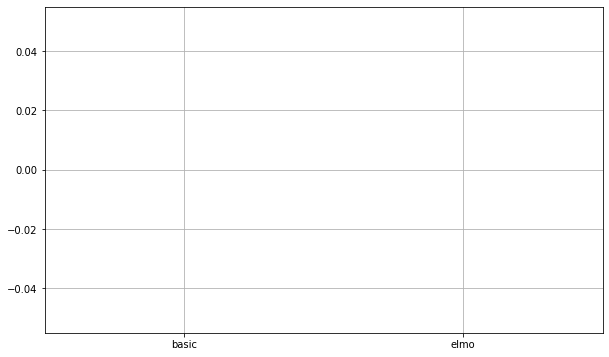

In [121]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

accuracies = pd.DataFrame({'basic' : basic_accuracies, 'elmo': elmo_accuracies})
plt.rcParams['figure.figsize'] = (10,6)
accuracies.boxplot()

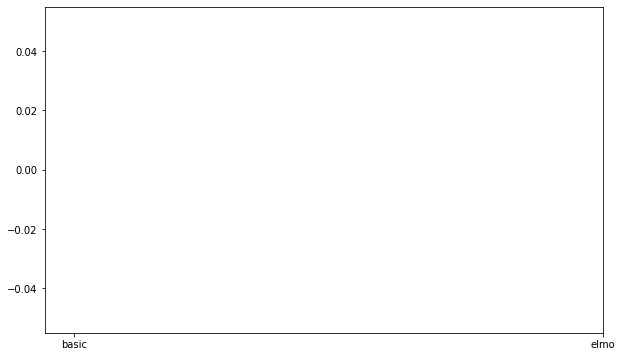

In [122]:
# Pair plot
plt.scatter(np.zeros(len(basic_accuracies)), basic_accuracies)
plt.scatter(np.ones(len(elmo_accuracies)), elmo_accuracies)

for i in range(len(basic_accuracies)):
    plt.plot( [0,1], [basic_accuracies[i], elmo_accuracies[i]], c='k')

plt.xticks([0,1], ['basic', 'elmo'])

plt.show()